### change point detection using the Python package ruptures 

#### simulation using simulated data with known change points

author: peter

date: 2024

Ruptures: 

C. Truong, L. Oudre, N. Vayatis. Selective review of offline change point detection methods. Signal Processing, 167:107299, 2020.

<li> https://centre-borelli.github.io/ruptures-docs/
<li> https://github.com/deepcharles/ruptures
<li> https://centre-borelli.github.io/ruptures-docs/user-guide/detection/
<li> see also https://schuetzgroup.github.io/sdt-python/changepoint.html



### simulation 
generate many simulated datasets and test each algorithm

metrics used to compare algorithm performance:
too early
MAE

In [27]:
import matplotlib.pylab as plt
import ruptures as rpt
import h5py
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import PercentFormatter

### run simulation and collect performance measurements

In [44]:

# outer loop for algorithm optimisation will go here
# TO DO


# set simulation parameters
rng = np.random.default_rng(12345)
#print(rng)
#rfloat = rng.random()

num_signals = 1000  # number of trials in simulation

mu, sigma = 0, 3 # mean and standard deviation
mu2, sigma2 = mu + 1, sigma + 1
n_bkps=1
true_onset=200

binseg_predictions = []
pelt_predictions = []
window_predictions = []
dyn_prog_predictions = []

for ii in range(num_signals):
    # generate signal
    s1 = rng.normal(mu, sigma, true_onset-1)
    s2 = rng.normal(mu2, sigma2, 251)
    signal= np.array(list(s1) + list(s2))
    times = np.arange(0, 451, 1).tolist()

    # algorithms: when using make defaults explicit
    # A new Pelt algorithm oblect must created for each trial.
    # This might also be true for other algorithm implmentations.
    
    ### predict onset
    # Binseg algorithm
    model = "l2"
    algo = rpt.Binseg(model=model).fit(signal)
    est_onset = algo.predict(n_bkps=n_bkps)
    binseg_predictions.append(est_onset[0])

    # Pelt algorithm
    model="rbf"
    algo = rpt.Pelt(model=model).fit(signal)
    est_onset = algo.predict(pen=2)           # penalty 1 --> early, 10 --> late
    pelt_predictions.append(est_onset[0])

    # window algorithm
    model = "l2"
    algo = rpt.Window(width=40, model=model).fit(signal)
    est_onset = algo.predict(n_bkps=n_bkps)
    window_predictions.append(est_onset[0])

    # Dynamic programming algorithm
    model = "l1"
    algo = rpt.Dynp(model=model, min_size=3, jump=5).fit(signal)
    est_onset = algo.predict(n_bkps=n_bkps)
    dyn_prog_predictions.append(est_onset[0])

### helper functions

In [45]:
def get_too_early(predictions, true_onset):
    pred_array = np.array(predictions)
    too_early = pred_array[pred_array < true_onset]
    too_early = np.abs(too_early - true_onset)
    return too_early


def get_pct_too_early(predictions, true_onset):
    pred_array = np.array(predictions)
    too_early = pred_array[pred_array < true_onset]
    pct_too_early = len(too_early)/len(predictions)
    return pct_too_early


def get_MAE(predictions, true_onset):
    pred_array = np.array(predictions)
    MAE = np.mean(np.abs(pred_array - true_onset))
    return MAE

def get_std(predictions, true_onset):
    pred_array = np.array(predictions)
    std = np.std(pred_array)
    return std

def plot_predictions(pred, title):
    pass

### plot prediction distribution for each algorithm

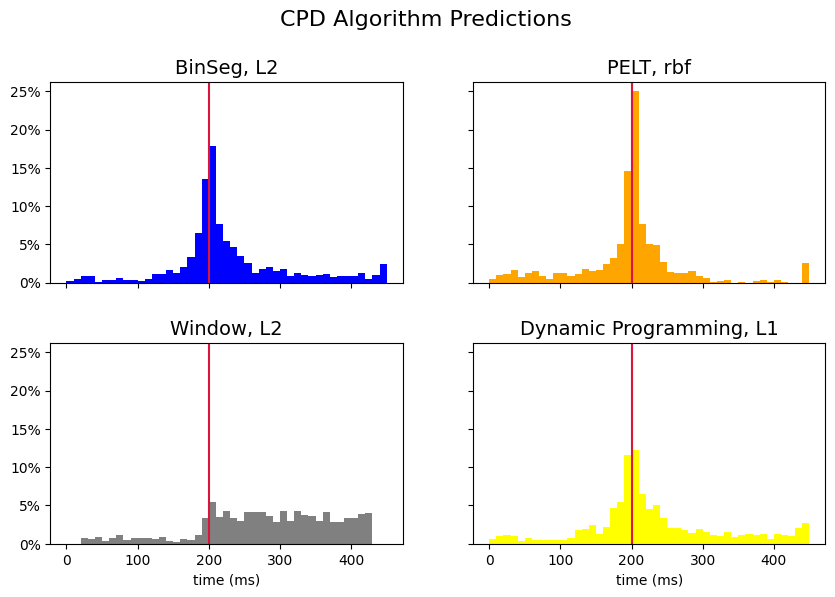

In [46]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True)
fig.suptitle('CPD Algorithm Predictions', y=1, fontsize=16)

fig.set_figwidth(10)
fig.set_figheight(6)

plt.subplots_adjust(hspace = 0.3)
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1,  decimals=0))

binwidth=10
bins = np.linspace(0, 450, 46)

temp=binseg_predictions
ax1.hist(temp, color='blue', bins=bins,  weights=np.ones(len(temp)) / len(temp))
ax1.set_title("BinSeg, L2", fontsize=14)
ax1.axvline(200, c="crimson", label="real onset")

temp=pelt_predictions
ax2.hist(temp, color='orange', bins=bins,  weights=np.ones(len(temp)) / len(temp))
ax2.set_title("PELT, rbf", fontsize=14)
ax2.axvline(200, c="crimson", label="real onset")

temp=window_predictions
ax3.hist(window_predictions, color='gray', bins=bins,  weights=np.ones(len(temp)) / len(temp))
ax3.set_title("Window, L2", fontsize=14)
ax3.set_xlabel("time (ms)")
ax3.axvline(200, c="crimson", label="real onset")

temp = dyn_prog_predictions
ax4.hist(dyn_prog_predictions, color='yellow', bins=bins,  weights=np.ones(len(temp)) / len(temp))
ax4.set_title("Dynamic Programming, L1", fontsize=14)
ax4.set_xlabel("time (ms)")
ax4.axvline(200, c="crimson", label="real onset")

for ax in fig.get_axes():
    ax.label_outer()

### plot distribution as in (Sassenhagen and Draschkow, 2019)

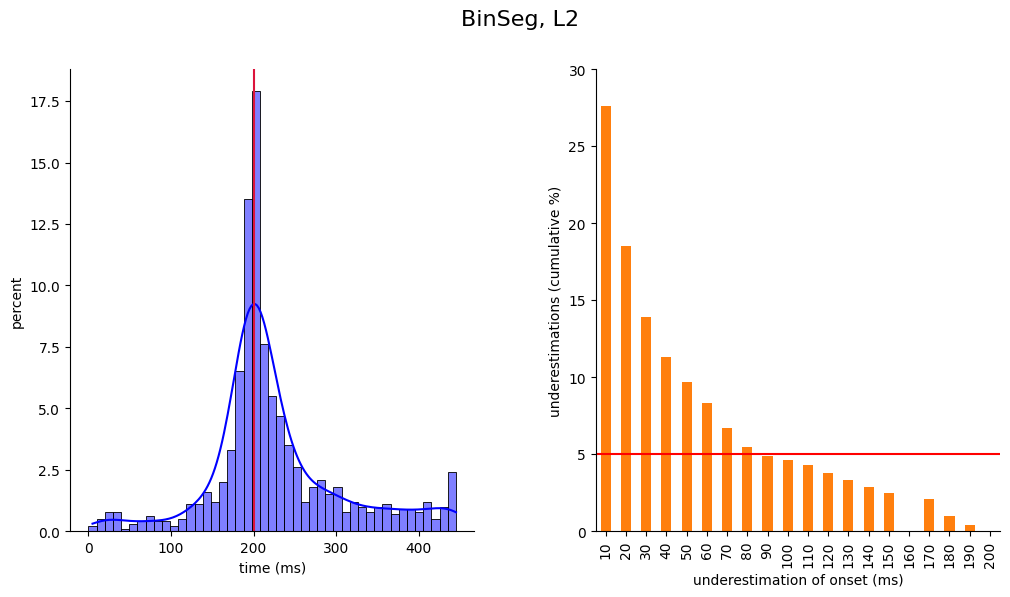

In [47]:
fig, [ax1, ax2] = plt.subplots(ncols=2)

fig.set_figwidth(12)
fig.set_figheight(6)

plt.suptitle('BinSeg, L2', fontsize=16)

# 10 ms time steps, 10ms bin width
binwidth=10
claims=binseg_predictions
bins = np.linspace(0, np.max(claims), 46)

sns.histplot(claims, kde=True, stat='percent', color='blue', ax=ax1, bins=bins) # kde=True???
ax1.set(xlabel='time (ms)', ylabel='percent')
ax1.axvline(200, c="crimson", label="real onset")
plt.subplots_adjust(wspace = 0.3)

total_claims = len(binseg_predictions) # total number of claims (predictions)

ax2.axhline(5, c="r", label="nominal 5% level")
ax2.set_ylabel("underestimations (cumulative %)")
ax2.set_xlabel("underestimation of onset (ms)")

ax2.set_xlim([10, 201])
ax2.set_xticks(range(10,201,10))
#s is a []
s = ( 100 * (pd.Series(([-min(r - true_onset, 0)  for r in claims ])).value_counts() / total_claims)
      .sort_index(ascending=False).cumsum().sort_index())[1:]

all_ticks = range(10, 201, 10)
s_full = pd.Series(index=all_ticks, dtype=float).fillna(0)

s_full.update( s )

# error (where detected onset is before true onset time)
s_full.plot(ax=ax2, kind="bar", color="C1")
ax2.set_yticks(ax2.get_yticks())
ax2.set_yticklabels([int(label) for label in ax2.get_yticks()])
sns.despine()

### get collection of measurements

In [48]:
MAE = get_MAE(binseg_predictions, true_onset)
std = get_std(binseg_predictions, true_onset)
print("BinSeg MAE =  %0.2f ms, std=%0.2f" % (MAE, std))

MAE = get_MAE(pelt_predictions, true_onset)
std = get_std(pelt_predictions, true_onset)
print("Pelt MAE   =  %0.2f ms, std=%0.2f" % (MAE, std) )

MAE = get_MAE(window_predictions, true_onset)
std = get_std(window_predictions, true_onset)
print("Window MAE = %0.2f ms, std=%0.2f" % (MAE, std) )

MAE = get_MAE(dyn_prog_predictions, true_onset)
std = get_std(dyn_prog_predictions, true_onset)
print("Dynamic Programming MAE = %0.2f ms, std=%0.2f" % (MAE, std) )

BinSeg MAE =  54.42 ms, std=81.60
Pelt MAE   =  44.72 ms, std=74.90
Window MAE = 104.67 ms, std=94.57
Dynamic Programming MAE = 67.49 ms, std=94.74
